In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
#import libraries for nerualnet, math and visualization
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
# from qkeras import *
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import mixed_precision
import sklearn.model_selection
from sklearn.preprocessing import normalize
import cv2
import sys
import os
import pathlib
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



# Import Data
dir = "/content/drive/MyDrive/Colab Notebooks/ECE_113DA/image-segmentation/Portseg_128/"

X_train_raw = np.load(dir + "img_uint8.npy")
Y_train = np.load(dir + "msk_uint8.npy")
X_test_raw = np.load(dir + "test_xtrain.npy")
Y_test = np.load(dir + "test_ytrain.npy")

y_len, x_len = X_train_raw.shape[1:3]
N_train = X_train_raw.shape[0]
N_test = X_test_raw.shape[0]
print(X_train_raw.shape, Y_train.shape, X_test_raw.shape, Y_test.shape)

# Convert to Greyscale
X_train = np.zeros((N_train, y_len, x_len, 1))
for i in range(N_train):
  X_train[i] = cv2.cvtColor(X_train_raw[i], cv2.COLOR_RGB2GRAY)[:,:,np.newaxis]
del X_train_raw

X_test = np.zeros((N_test, y_len, x_len, 1))
for i in range(N_test):
  X_test[i] = cv2.cvtColor(X_test_raw[i], cv2.COLOR_RGB2GRAY)[:,:,np.newaxis]
del X_test_raw

Y_train = Y_train / 255
Y_test = Y_test / 255

print("Finished")

2.4.1
Found GPU at: /device:GPU:0
(18698, 128, 128, 3) (18698, 128, 128, 1) (3740, 128, 128, 3) (3740, 128, 128, 1)
Finished


In [ ]:
def get_model(img_size, num_classes, z):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    # x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [16, 32]:
        # x = layers.Activation("relu")(x)
        # x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        # x = layers.Activation("relu")(x)
        # x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###
    for filters in [32, 16, 2]:
        # x = layers.Activation("relu")(x)
        # x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        # x = layers.Activation("relu")(x)
        # x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
num_classes = 2
img_size = (y_len, x_len)
z = 2
model = get_model(img_size, num_classes, z)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   2320        activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
# num_classes = 2
# img_size = (y_len, x_len)

# filter_num = [1,2,4,6,8,10,12,14,16]
# filter_num = [1,2]
# for x in filter_num:
# keras.backend.clear_session()
# model = get_model(img_size, num_classes, x)
# model.summary()

# X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.15)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",  metrics=['accuracy'])

# Train the model, doing validation at the end of each epoch.
epochs = 25
# history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.15, callbacks=callbacks)
history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.15, verbose=1)

loss, accuracy = model.evaluate(X_test, Y_test)

print("Final Layer # Filters:", z)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

print(loss, accuracy)

Epoch 1/25
497/497 [==============================] - 12s 21ms/step - loss: 1.4785 - accuracy: 0.7356 - val_loss: 0.3356 - val_accuracy: 0.8558
Epoch 2/25
497/497 [==============================] - 10s 20ms/step - loss: 0.2673 - accuracy: 0.8887 - val_loss: 0.2750 - val_accuracy: 0.8830
Epoch 3/25
346/497 [===================>..........] - ETA: 2s - loss: 0.2128 - accuracy: 0.9129

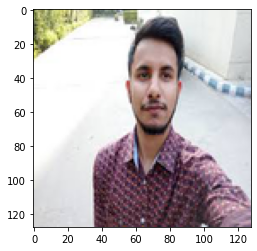

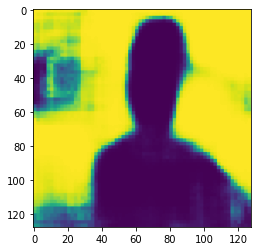

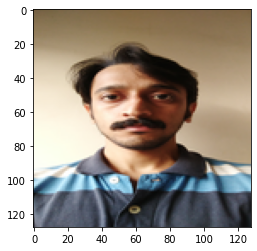

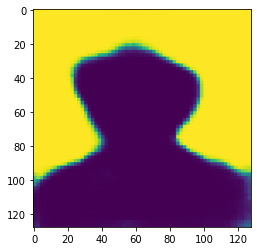

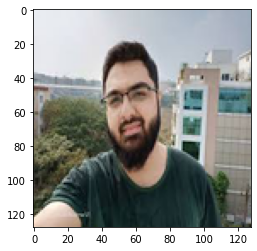

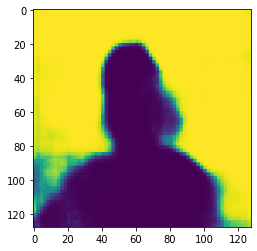

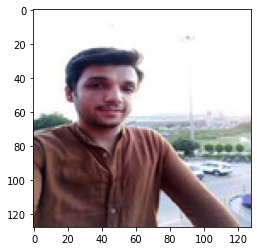

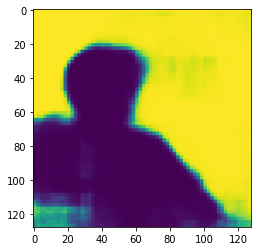

In [ ]:
test_images_raw = np.load(dir + "test_uint8.npy")
N_test_images = test_images_raw.shape[0]
test_images = np.zeros((N_test_images, y_len, x_len, 1))
# plt.imshow(test_images_raw[0])

for i in np.arange(N_test_images):
  test_images[i] = cv2.cvtColor(test_images_raw[i], cv2.COLOR_RGB2GRAY)[:,:,np.newaxis]
  prediction = model.predict(test_images[i][np.newaxis,:,:,:])
  plt.figure()
  plt.imshow(test_images_raw[i])
  plt.figure()
  plt.imshow(prediction[0,:,:,0])

## TF Lite Post-Training Quantization

https://www.tensorflow.org/lite/performance/post_training_float16_quant

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# tflite_models_dir = pathlib.Path(dir + "../")
tflite_models_dir = pathlib.Path('/content/drive/MyDrive/')
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"unet_hersh.tflite"
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"unet_hersh_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmpx73qvfz7/assets


INFO:tensorflow:Assets written to: /tmp/tmpx73qvfz7/assets


INFO:tensorflow:Assets written to: /tmp/tmpk5g76niu/assets


INFO:tensorflow:Assets written to: /tmp/tmpk5g76niu/assets


150608

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_fp16_model,  "unet_hersh")

with  open('unet_hersh.h',  'w')  as  file:
    file.write(header_text)

with  open('unet_hersh.cc',  'w')  as  file:
    file.write(source_text)

## Testing TF Lite Model

(1, 128, 128, 1)


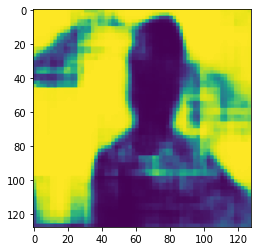

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

# test_image = test_images[0][np.newaxis,:,:,:]
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)
print(test_image.shape)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

plt.imshow(predictions[0,:,:,0])

## TF Lite --> .cc

In [ ]:
MODELS_DIR = dir + "../"
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'unet_hersh.tflite'
MODEL_TFLITE = MODELS_DIR + 'unet_hersh_quant_f16.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'unet_hersh_quant_f16.cc'


In [ ]:
!xxd -i {'/content/drive/MyDrive/unet_hersh_quant_f16.tflite'} > {'/content/drive/MyDrive/unet_hersh_quant_f16.cc'}
# Update variable names
# REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
# !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
# def get_model(img_size, num_classes, final_layer_num_filters):
#     inputs = keras.Input(shape=img_size + (1,))

#     ### [First half of the network: downsampling inputs] ###
#     x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
#     # x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [32, 48]:
#         # x = layers.Activation("relu")(x)
#         # x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.Conv2D(filters, 3, padding="same")(x)
#         x = layers.Activation("relu")(x)
#         x = layers.BatchNormalization()(x)

#         # # x = layers.Activation("relu")(x)
#         # # x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         # x = layers.Conv2D(filters, 3, padding="same")(x)
#         # x = layers.Activation("relu")(x)
#         # x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###
#     for filters in [48, 32, 16]:
#         # x = layers.Activation("relu")(x)
#         # x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.Conv2D(filters, 3, padding="same")(x)
#         x = layers.Activation("relu")(x)
#         x = layers.BatchNormalization()(x)

#         # # x = layers.Activation("relu")(x)
#         # # x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         # x = layers.Conv2D(filters, 3, padding="same")(x)
#         # x = layers.Activation("relu")(x)
#         # x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

#     # Define the model
#     model = keras.Model(inputs, outputs)
#     return model

# # Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()

# # policy = mixed_precision.Policy('mixed_float16')
# # mixed_precision.set_global_policy(policy)

# # Build model
# num_classes = 2
# img_size = (y_len, x_len)
# # model = get_model(img_size, num_classes)
# # model.summary()